# Libararies

In [2]:
from datasets import load_dataset
import nltk
nltk.download('punkt')  
from nltk.tokenize import sent_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import numpy as np
import random
from nltk.corpus import stopwords
nltk.download('stopwords')  
stop_words = set(stopwords.words('english'))
import string
punctuation_marks = set(string.punctuation)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Dataset

In [3]:
# Load the RACE dataset using the datasets library
dataset = load_dataset("race", "all")

README.md:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/37.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4934 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/87866 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4887 [00:00<?, ? examples/s]

# Data Preprocessing

## Sentences Extraction

In [4]:
# Initialize an empty list to store sentences
sentences = []

# Iterate over each split in the dataset
for split in ['train', 'validation', 'test']:
    # Iterate over each example in the split
    for item in dataset[split]:
        passage = item['article']
        # Tokenize the passage into sentences
        passage_sentences = sent_tokenize(passage)
        # Extend the sentences list
        sentences.extend(passage_sentences)

## Fill-in-the-blank Questions

In [5]:
import random

data = []
min_length = 8  # Minimum sentence length to be processed

In [6]:
for sentence in sentences:
    # Tokenize sentence
    words = word_tokenize(sentence)
    
    # Ensure sentence length
    if len(words) < min_length:
        continue
    
    # Calculate halfway point
    half_point = len(words) // 2

    # Randomly select a blank index in the first half of the sentence
    blank_index = random.randint(1, half_point - 1)  
    missing_word = words[blank_index]

    # Skip uninformative missing words
    if missing_word.lower() in stop_words or missing_word in punctuation_marks:
        continue

    # Split into Part A and Part B
    part_a_words = words[:blank_index]
    part_b_words = words[blank_index + 1:]

    # Skip if Part B is empty or contains only punctuation
    if not part_b_words or all(word in punctuation_marks for word in part_b_words):
        continue

    # Create Part A and reversed Part B
    part_a = ' '.join(part_a_words)
    part_b_reversed = ' '.join(part_b_words[::-1])
    sentence_without_blank = ' '.join(words[:blank_index] + words[blank_index + 1:])

    # Append to data
    data.append({
        'original_sentence': sentence,
        'sentence_without_blank': sentence_without_blank,
        'missing_word': missing_word,
        'blank_index': blank_index,
        'part_a': part_a,
        'part_b_reversed': part_b_reversed,
        'words': words
    })

## Verifying Data

In [7]:
# Validate processed data for any remaining issues
for i, item in enumerate(data[:10]):  # Checking first 10 samples for validation
    print(f"Original Sentence: {item['original_sentence']}")
    print(f"Sentence without Blank: {item['sentence_without_blank']}")
    print(f"Missing Word: {item['missing_word']}")
    print(f"Part A: {item['part_a']}")
    print(f"Part B Reversed: {item['part_b_reversed']}")
    print('-' * 50)
    
    # Additional checks
    if not item['part_a'] or not item['part_b_reversed']:
        print(f"Issue found in item {i} - Part A or Part B Reversed is empty.")

Original Sentence: Given that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help".
Sentence without Blank: Given that I students who are training to be doctors , I was surprised do find that most thought that they would not be able to get the jobs they wanted without `` outside help '' .
Missing Word: teach
Part A: Given that I
Part B Reversed: . '' help outside `` without wanted they jobs the get to able be not would they that thought most that find do surprised was I , doctors be to training are who students
--------------------------------------------------
Original Sentence: "What kind of help is that?"
Sentence without Blank: `` What of help is that ? ''
Missing Word: kind
Part A: `` What
Part B Reversed: '' ? that is help of
--------------------------------------------------
Original Sentence: One girl told me that she was considering surgery to increase her heigh

# Balancing the data

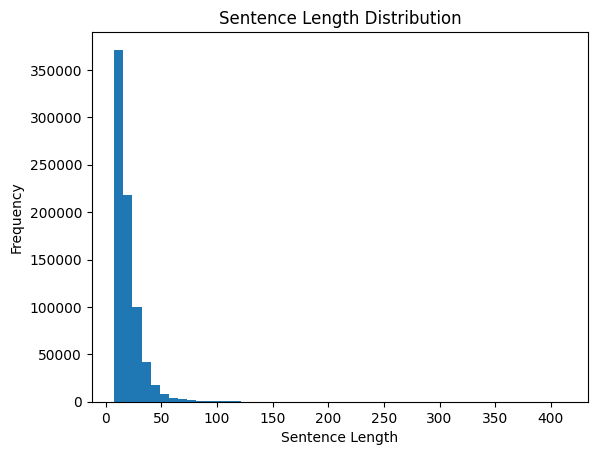

Original data size: 769132
Balanced data size: 497775
Final data size: 276793


In [8]:
# Analyze sentence length distribution
sentence_lengths = [len(item['words']) for item in data]
import matplotlib.pyplot as plt

plt.hist(sentence_lengths, bins=50)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

# Set minimum and maximum sentence length
min_length = 8
max_length = 20

# Filter data based on sentence length
balanced_data = [item for item in data if min_length <= len(item['words']) <= max_length]

# Limit the number of examples per missing word
word_frequencies = Counter([item['missing_word'] for item in balanced_data])
max_examples_per_word = 100  

word_counts = {}
final_data = []

for item in balanced_data:
    word = item['missing_word']
    count = word_counts.get(word, 0)
    if count < max_examples_per_word:
        final_data.append(item)
        word_counts[word] = count + 1

# Check the final dataset size
print(f"Original data size: {len(data)}")
print(f"Balanced data size: {len(balanced_data)}")
print(f"Final data size: {len(final_data)}")

# Update data variable to final_data for further processing
data = final_data

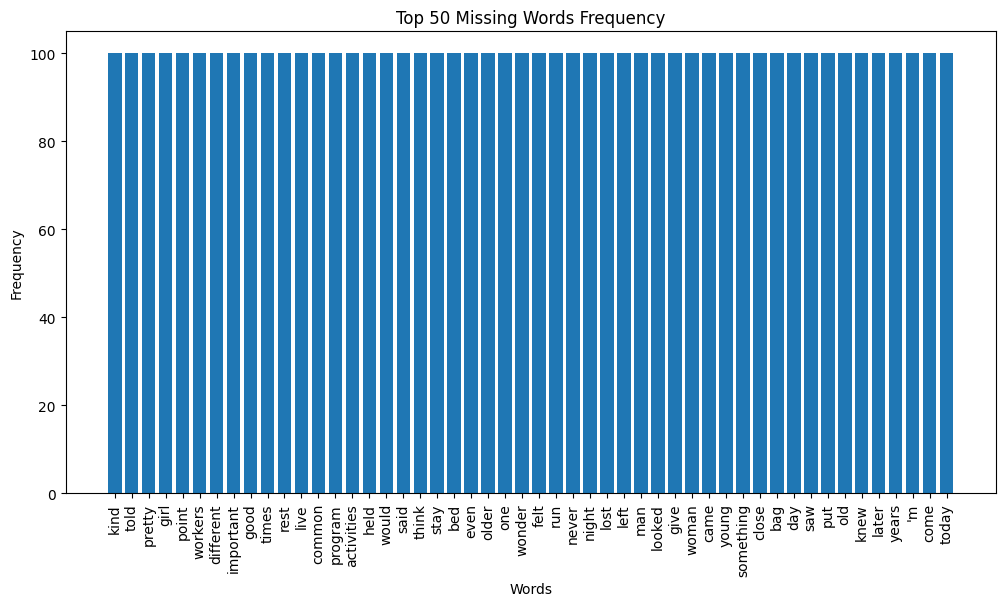

In [9]:
import matplotlib.pyplot as plt

word_counts_final = Counter([item['missing_word'] for item in final_data])
plt.figure(figsize=(12,6))
word_counts_final.most_common(50)
words, counts = zip(*word_counts_final.most_common(50))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Missing Words Frequency')
plt.show()

# Tokenization and Vocabulary Building

In [10]:
# Initialize a Counter to keep track of word frequencies
token_counts = Counter()

In [11]:
# Collect all tokens
for item in data:
    # Tokens from part_a and part_b_reversed
    tokens = item['part_a'].split() + item['part_b_reversed'].split()
    # Include the missing word
    tokens.append(item['missing_word'])
    # Update the token counts
    token_counts.update(tokens)

In [12]:
# Define special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

# Define the maximum vocabulary size
max_vocab_size = 5000  

# Get the most common tokens
most_common_tokens = token_counts.most_common(max_vocab_size - 2)  # Subtract special tokens

# Rebuild the vocabulary
vocab_tokens = [PAD_TOKEN, UNK_TOKEN] + [token for token, _ in most_common_tokens]

# Recreate token mappings
token_to_index = {token: idx for idx, token in enumerate(vocab_tokens)}
index_to_token = {idx: token for token, idx in token_to_index.items()}

# Vocabulary size
vocab_size = len(vocab_tokens)
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 5000


In [13]:
# Function to convert a list of tokens to indices
def tokens_to_indices(tokens, token_to_index):
    return [token_to_index.get(token, token_to_index[UNK_TOKEN]) for token in tokens]

In [14]:
# Process each item in the data list
for item in data:
    # Convert part_a to indices
    part_a_tokens = item['part_a'].split()
    item['part_a_indices'] = tokens_to_indices(part_a_tokens, token_to_index)
    # Convert part_b_reversed to indices
    part_b_tokens = item['part_b_reversed'].split()
    item['part_b_indices'] = tokens_to_indices(part_b_tokens, token_to_index)
    # Convert missing_word to index
    item['missing_word_index'] = token_to_index.get(item['missing_word'], token_to_index[UNK_TOKEN])

In [15]:
# Determine maximum sequence lengths
max_len_part_a = max(len(item['part_a_indices']) for item in data)
max_len_part_b = max(len(item['part_b_indices']) for item in data)

print(f"Max length of Part A sequences: {max_len_part_a}")
print(f"Max length of Part B sequences: {max_len_part_b}")

Max length of Part A sequences: 9
Max length of Part B sequences: 18


In [16]:
from keras.preprocessing.sequence import pad_sequences

# Get the index for the PAD token
pad_index = token_to_index[PAD_TOKEN]
unk_index = token_to_index[UNK_TOKEN]

# Pad the sequences
for item in data:
    # Pad part_a_indices
    item['part_a_padded'] = pad_sequences([item['part_a_indices']], maxlen=max_len_part_a, padding='post', value=pad_index)[0]
    # Pad part_b_indices
    item['part_b_padded'] = pad_sequences([item['part_b_indices']], maxlen=max_len_part_b, padding='post', value=pad_index)[0]


In [17]:
# Prepare inputs and targets
part_a_inputs = np.array([item['part_a_padded'] for item in data])
part_b_inputs = np.array([item['part_b_padded'] for item in data])
targets = np.array([item['missing_word_index'] for item in data])
# Filter out padding tokens from targets
targets = [target for target in targets if target != pad_index]

# Pre-trained Embeddings

In [18]:
embedding_dim = 100  
embedding_index = {}

print("Loading GloVe embeddings...")
with open('/kaggle/input/glove-6b/glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector
print("Loaded {} word vectors.".format(len(embedding_index)))

Loading GloVe embeddings...
Loaded 400000 word vectors.


In [19]:
# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in token_to_index.items():
    if idx < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            # Initialize embeddings for unknown words
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Model Implementation

In [20]:
subset_size = 200000  
subset_data = data[:subset_size]

## LSTM Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
num_classes = vocab_size  # Vocabulary size includes PAD and UNK tokens
targets_categorical = to_categorical(targets, num_classes=num_classes)

In [23]:
# Define input shape and ensure input data is of type int32
input_length_part_a = part_a_inputs.shape[1]  # Max length of Part A sequences
input_part_a = Input(shape=(input_length_part_a,), dtype='int32')

# Ensure embedding_matrix has the correct shape and dtype
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Expected shape: ({vocab_size}, {embedding_dim})")
embedding_matrix = np.array(embedding_matrix, dtype='float32')

Embedding matrix shape: (5000, 100)
Expected shape: (5000, 100)


### Forward LSTM

In [36]:
# Define regularization strength
l2_strength = 0.01

# Define input shapes
input_length_part_a = part_a_inputs.shape[1]
input_length_part_b = part_b_inputs.shape[1]

# Define input layers with explicit sequence lengths
input_part_a = Input(shape=(max_len_part_a,), dtype='int32')
input_part_b = Input(shape=(max_len_part_b,), dtype='int32')

# Use the same embedding layer for both parts
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=True
)

# Embed both parts
embedded_part_a = embedding_layer(input_part_a)
embedded_part_b = embedding_layer(input_part_b)

# Apply LSTM layers
lstm_units = 256
lstm_part_a = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedded_part_a)
lstm_part_b = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedded_part_b)

# Apply attention mechanism to each part
attention_a = Attention()([lstm_part_a, lstm_part_a])
attention_b = Attention()([lstm_part_b, lstm_part_b])

# Pool to combine the attended outputs
attention_a = GlobalAveragePooling1D()(attention_a)
attention_b = GlobalAveragePooling1D()(attention_b)

# Concatenate the outputs
combined = Concatenate()([attention_a, attention_b])
combined = Dropout(0.3)(combined)

# Dense output layer
output_layer = Dense(
    num_classes, 
    activation='softmax', 
    kernel_regularizer=l2(l2_strength)
)(combined)

# Define the model
model_combined = Model(inputs=[input_part_a, input_part_b], outputs=output_layer)

# Compile the model
model_combined.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary to verify
model_combined.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 18, 100)   │    500,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 9, 512)    │    731,136 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 18, 512)   │    731,136 │ embedding_1[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 9, 512)    │          0 │ bidirectional_2[… │
│ (Attention)         │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 18, 512)   │          0 │ bidirectional_3[… │
│ (Attention)         │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ attention_3[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5000)      │  5,125,000 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,087,272 (27.04 MB)

 Trainable params: 7,087,272 (27.04 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [38]:
from sklearn.model_selection import train_test_split

# Ensure that targets is a NumPy array
targets = np.array(targets)

targets_sparse = targets.astype(np.int32)

# Split data for Forward LSTM
X_train_a, X_val_a, y_train, y_val = train_test_split(
    part_a_inputs, targets_sparse, test_size=0.2, random_state=42
)

# Split data for Backward LSTM
X_train_b, X_val_b, _, _ = train_test_split(
    part_b_inputs, targets_sparse, test_size=0.2, random_state=42
)

y_val = [y for y in y_val if y != pad_index]

In [39]:
# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [40]:
print("Shape of part_a_inputs:", part_a_inputs.shape)
print("Shape of part_b_inputs:", part_b_inputs.shape)
print("Shape of targets_sparse:", targets_sparse.shape)
print("Shape of X_val_a:", X_val_a.shape)
print("Shape of X_val_b:", X_val_b.shape)
y_val = np.array(y_val)
print("Shape of y_val:", y_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of part_a_inputs: (276793, 9)
Shape of part_b_inputs: (276793, 18)
Shape of targets_sparse: (276793,)
Shape of X_val_a: (55359, 9)
Shape of X_val_b: (55359, 18)
Shape of y_val: (55359,)
Shape of y_val: (55359,)


In [41]:
# Train model
history_combined = model_combined.fit(
    [part_a_inputs, part_b_inputs],
    targets_sparse,
    validation_data=([X_val_a, X_val_b], y_val),
    batch_size=64,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 75s 16ms/step - accuracy: 0.2383 - loss: 8.1950 - val_accuracy: 0.2381 - val_loss: 7.9062 - learning_rate: 0.0100
Epoch 2/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 70s 16ms/step - accuracy: 0.2408 - loss: 7.9910 - val_accuracy: 0.2381 - val_loss: 8.3164 - learning_rate: 0.0100
Epoch 3/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 70s 16ms/step - accuracy: 0.2403 - loss: 8.1827 - val_accuracy: 0.2381 - val_loss: 8.1538 - learning_rate: 0.0100
Epoch 4/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - accuracy: 0.2404 - loss: 7.0613 - val_accuracy: 0.2381 - val_loss: 7.1041 - learning_rate: 0.0020
Epoch 5/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - accuracy: 0.2409 - loss: 7.0978 - val_accuracy: 0.2381 - val_loss: 7.1336 - learning_rate: 0.0020
Epoch 6/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 70s 16ms/step - accuracy: 0.2391 - loss: 7.1355 - val_accuracy: 0.2381 - val_loss: 7.1476 - learning_rate: 0.0020
Epoch 7/20
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - accura

### Training Forward LSTM

In [30]:
# # Train the Forward LSTM model# history_forward = model_forward.fit(#     X_train_a,#     y_train,#     validation_data=(X_val_a, y_val),#     batch_size=16,#     epochs=20,# )

### Training Backward LSTM

In [31]:
# # Train the Backward LSTM model# history_backward = model_backward.fit(#     X_train_b,#     y_train,#     validation_data=(X_val_b, y_val),#     batch_size=32,#     epochs=20,# )

## Evaluation

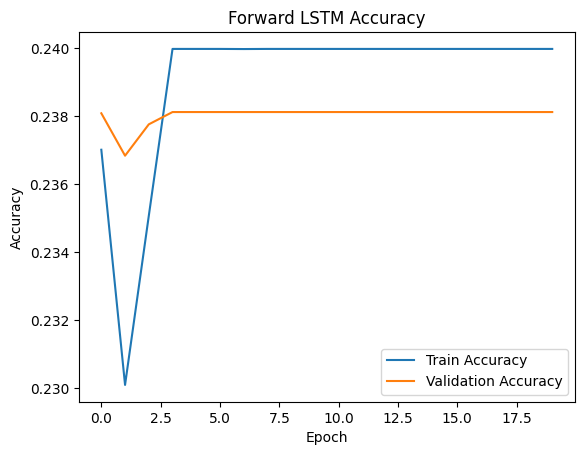

In [32]:
import matplotlib.pyplot as plt

plt.plot(history_combined.history['accuracy'], label='Train Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Forward LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# # Forward LSTM
# plt.plot(history_forward.history['accuracy'], label='Train Accuracy')
# plt.plot(history_forward.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Forward LSTM Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Backward LSTM
# plt.plot(history_backward.history['accuracy'], label='Train Accuracy')
# plt.plot(history_backward.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Backward LSTM Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [33]:
# Evaluate Combined Model on validation data using both inputs
val_loss_combined, val_accuracy_combined = model_combined.evaluate([X_val_a, X_val_b], y_val)
print(f"Combined Model Validation Loss: {val_loss_combined}, Validation Accuracy: {val_accuracy_combined}")

1730/1730 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2386 - loss: 6.9200
Combined Model Validation Loss: 6.923402309417725, Validation Accuracy: 0.2381184697151184


# Testing the Model

In [34]:
def filter_pad_unk(predictions, pad_index, unk_index):
    predictions[:, pad_index] = 0
    predictions[:, unk_index] = 0
    return predictions

In [35]:
num_samples = 10
sample_indices = np.random.choice(len(X_val_a), num_samples, replace=False)

for idx in sample_indices:
    # Get the inputs for both parts
    input_a = X_val_a[idx].reshape(1, -1)
    input_b = X_val_b[idx].reshape(1, -1)
    
    # Get the true missing word
    true_word_index = y_val[idx]  
    true_word = index_to_token[true_word_index]
    
    # Predict with Combined Model
    pred_combined = model_combined.predict([input_a, input_b])
    pred_combined = filter_pad_unk(pred_combined, pad_index, unk_index)
    pred_word_index_combined = np.argmax(pred_combined)
    pred_word_combined = index_to_token[pred_word_index_combined]
    
    # Print results
    print(f"True Missing Word: {true_word}")
    print(f"Combined Model Prediction: {pred_word_combined}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
True Missing Word: circle
Combined Model Prediction: workers
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Missing Word: expecting
Combined Model Prediction: died
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
True Missing Word: <UNK>
Combined Model Prediction: holiday
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Missing Word: <UNK>
Combined Model Prediction: workers
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Missing Word: married
Combined Model Prediction: workers
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True Missing Word: sharks
Combined Model Prediction: holiday
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
True Missing Word: became
Combined Model Prediction: workers
-